In [1]:
import numpy as np
import cv2
import numpy as np
import cv2
import os
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.widgets import RectangleSelector
import math

In [ ]:
np.random.seed(42)

n_components = 10

mat_files = sorted([file for file in os.listdir("data_np/") if file.endswith('.npy')])
idx = 31

image_sequence = np.load('data_np/' + mat_files[idx])
image_sequence = image_sequence[135:, :, :]
roi_coords = []

In [3]:
print(mat_files[idx])

Flash_transm_50Hz_5J_Tamb_2.npy


Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


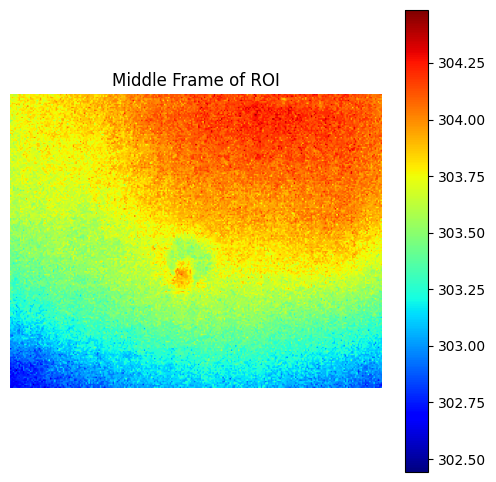

In [4]:
h, w, t = image_sequence.shape

middle_frame = image_sequence[:, :, t // 2]
frame_8bit = cv2.normalize(middle_frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
colored = cv2.applyColorMap(frame_8bit, cv2.COLORMAP_JET)

roi = cv2.selectROI("Select ROI", colored, showCrosshair=True)
cv2.destroyAllWindows()

x, y, w_roi, h_roi = roi
image_sequence = image_sequence[y:y+h_roi, x:x+w_roi, :]

t = image_sequence.shape[2]
middle_frame = image_sequence[:, :, t // 2]

plt.figure(figsize=(6, 6))
plt.imshow(middle_frame, cmap='jet')
plt.title('Middle Frame of ROI')
plt.axis('off')
plt.colorbar()
plt.show()

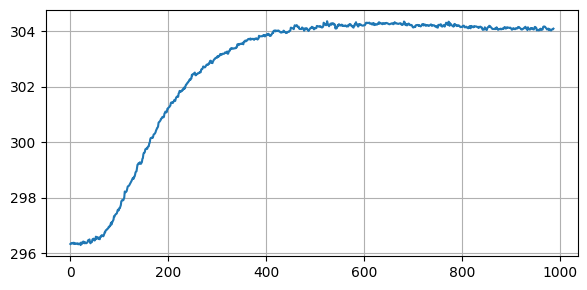

123


In [5]:
h, w, sequence_size = image_sequence.shape
plt.figure(figsize=(6, 3))
plt.plot(image_sequence.reshape(h * w, sequence_size)[5000,13:1000])
plt.grid(True)
plt.tight_layout()
plt.show()

diff = np.diff(image_sequence.reshape(h * w, sequence_size)[5000,:1000])
t_pulse = np.argmax(diff)
print(t_pulse)
t_pulse = 70

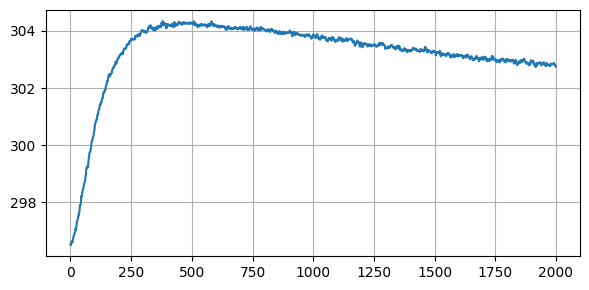

In [6]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

h, w, sequence_size = image_sequence.shape
imageMatrix = image_sequence.reshape(h * w, sequence_size)
imageMatrix = imageMatrix[:, t_pulse:]

original_len = imageMatrix.shape[1]
target_len = 2000

x_old = np.linspace(0, 1, original_len)
x_new = np.linspace(0, 1, target_len)

f = interp1d(x_old, imageMatrix, kind="linear", axis=1)
imageMatrix = f(x_new)

plt.figure(figsize=(6, 3))
plt.plot(imageMatrix[5000, :])
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
imageMatrix = imageMatrix - np.mean(imageMatrix, axis=1, keepdims=True)

U, S, Vh = np.linalg.svd(imageMatrix, full_matrices=False)

Vh = Vh[:n_components, :]

principal_comp = np.matmul(imageMatrix, Vh.T)

pca_array = principal_comp.reshape(h, w, n_components)
pca_array = pca_array.transpose(2, 0, 1)

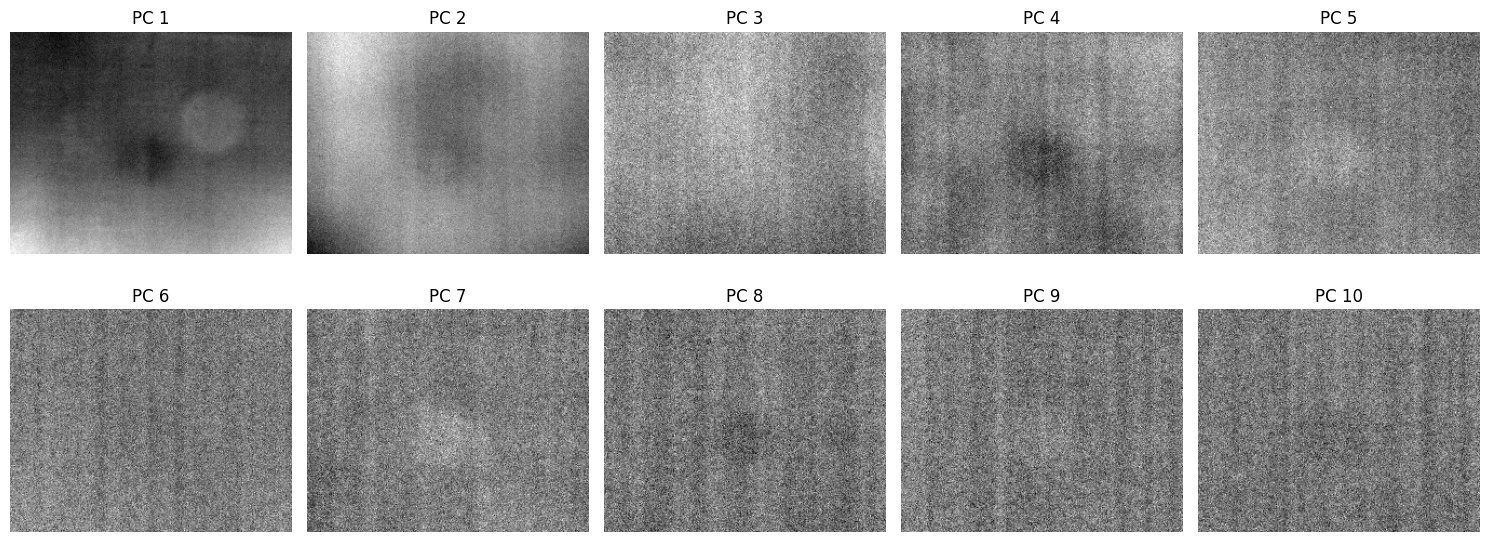

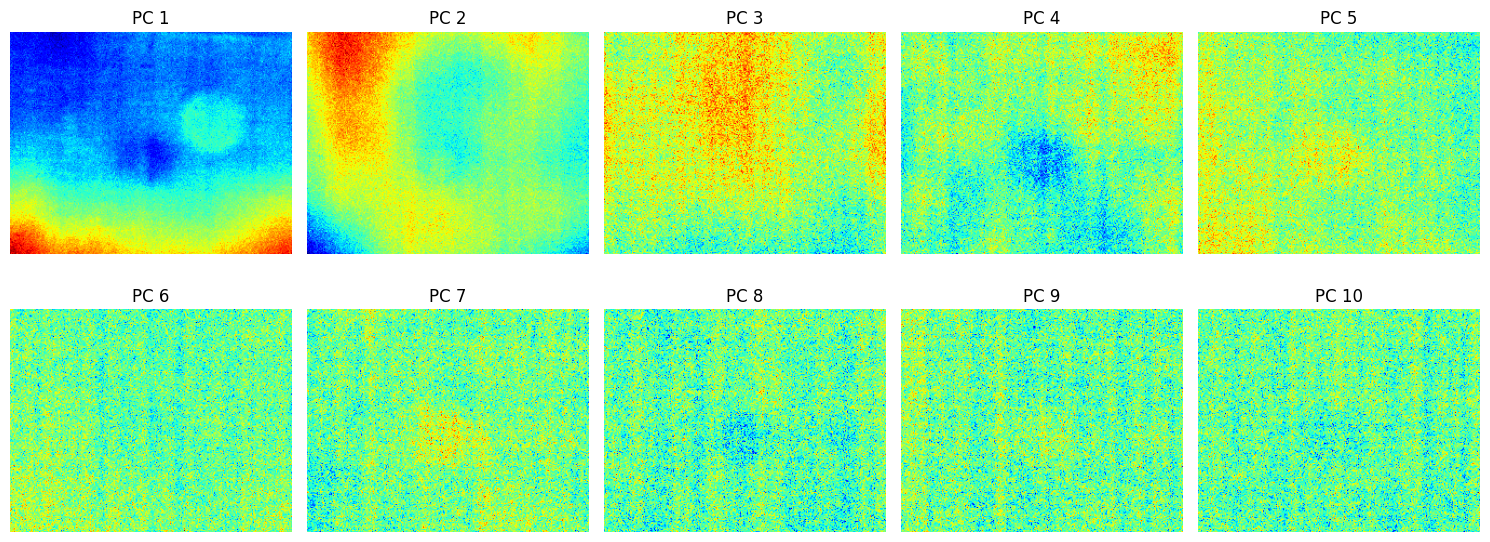

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='jet')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

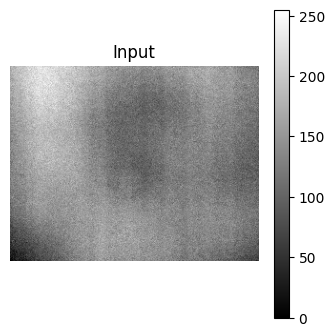

In [9]:
import torch
import cv2
import numpy as np
import os

comp = pca_array[1, :, :]

comp -= comp.min()
comp /= (comp.max() + 1e-8)
comp = (comp * 255).astype(np.uint8)

gray_8u = cv2.normalize(comp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
bgr = cv2.applyColorMap(gray_8u, cv2.COLORMAP_JET)
# img_rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
img_rgb = cv2.cvtColor(gray_8u, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(4, 4))
plt.imshow(img_rgb, cmap='gray')
plt.title(f'Input')
plt.axis('off')
plt.colorbar()
plt.show()

In [10]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.generation import GenerationConfig
import torch

torch.manual_seed(1234)

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen-VL-Chat", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen-VL-Chat", device_map="auto", trust_remote_code=True, fp16=True).eval()

if hasattr(model, "generation_config"):
    model.generation_config.use_cache = False
    model.generation_config.do_sample = False
    model.generation_config.temperature = 0.0
    model.generation_config.top_p = 1.0
    model.generation_config.max_new_tokens = 512

/home/m123/anaconda3/envs/cogvlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


In [11]:
from PIL import Image, ImageDraw

image = Image.fromarray(img_rgb).convert("RGB")
W, H = image.size

save_path = "temp_image.jpg"
image.save(save_path)

In [14]:
import os, re

system = (
    "You are an expert inspection assistant. "
    "Task: Detect the defects and describe their location. "
    "Follow these rules strictly: "
    "1) Output format must be exactly <ref>defect</ref><box>(x1,y1),(x2,y2)</box>. "
    "2) Use integer pixel coordinates for the thermal image; (x1,y1) is top-left, (x2,y2) is bottom-right, and x2>x1, y2>y1. "
    "3) If uncertain, output exactly <ref>none</ref><box>(0,0),(0,0)</box>. "
    "4) No extra text, no explanations. "
)

q1 = tokenizer.from_list_format([
    {"image": save_path},
    {"text": "Detect the defects and describe their location. Return only the requested format."}
])
_, history = model.chat(tokenizer, query=q1, history=None, system=system, use_cache=False)

ask = 'Return the defect locations only as <ref>defect</ref><box>(x1,y1),(x2,y2)</box>.'
resp, history = model.chat(tokenizer, ask, history=history, system=system, use_cache=False)

m = re.search(r"<ref>(.*?)</ref>\s*<box>\((\d+),\s*(\d+)\),\((\d+),\s*(\d+)\)</box>", resp)
if not m:
    resp, history = model.chat(tokenizer, "The format was invalid. Repeat the box exactly in the required format.", history=history, system=system, use_cache=False)
    m = re.search(r"<ref>(.*?)</ref>\s*<box>\((\d+),\s*(\d+)\),\((\d+),\s*(\d+)\)</box>", resp)

verify = "Verify the boxes are tight and correct. If correct, repeat identically; otherwise return corrected boxes in the exact same format."
resp2, history = model.chat(tokenizer, verify, history=history, system=system, use_cache=False)
m2 = re.search(r"<ref>(.*?)</ref>\s*<box>\((\d+),\s*(\d+)\),\((\d+),\s*(\d+)\)</box>", resp2)
final_resp = resp2 if m2 else resp

image = tokenizer.draw_bbox_on_latest_picture(final_resp, history)
if image:
    image.save("defect_box.jpg")
else:
    print("no box")
print(final_resp)

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


<ref> defect</ref><box>(377,100),(623,573)</box>
